# 在Fastai框架下基于BERT模型的中文文本分类


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## Preparation

In [3]:
#安装pytorch下包含BERT预训练模型的库
# !pip install pytorch-pretrained-bert

In [1]:
#引入必要的依赖包
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [44]:
#设置一个config类，便于参数配置与更改
class Config1(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config1(
    testing=False,
    bert_model_name="bert-base-chinese", 
    #选用中文预训练模型：Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters
    max_lr=3e-5,
    epochs=5,
    use_fp16=False, #fastai里可以方便地调整精度，加快训练速度：learner.to_fp16()
    bs=8,
    max_seq_len=128, #选取合适的seq_length，较大的值可能导致训练极慢报错等
)

In [71]:
root = Path('~/.fastai/data/xiecheng/')

In [2]:
Config

fastai.datasets.Config

## Customize Tokenizer and Vocab

In [6]:
#pytorch_bert包提供了BertTokenizer类，从选取的模型中提取tok
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

定制Tokenizer需要继承fastai的BaseTokenizer类，注意BERT会在sequence的首尾加上特殊token[CLS]和[SEP]，与fastai里的bos和eos有重合，所以在之后会有include_eos=Fasle的设置

In [7]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around a BertTokenizer to be a BaseTokenizer in fastai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [8]:
#最终的tokenizer
fastai_tokenizer = Tokenizer(
    tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), 
    pre_rules=[], 
    post_rules=[]
)

In [9]:
#check the vocab
list(bert_tok.vocab.items())[1000:1010]

[('傲', 1000),
 ('傳', 1001),
 ('債', 1002),
 ('傷', 1003),
 ('傻', 1004),
 ('傾', 1005),
 ('僅', 1006),
 ('働', 1007),
 ('像', 1008),
 ('僑', 1009)]

In [10]:
#设置vocab
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

## Dataset

本次使用的数据集信息：

*   名称及出处：[ChnSentiCorp_htl_all](https://github.com/ZeroLeon/ChineseNlpCorpus/blob/master/datasets/ChnSentiCorp_htl_all/intro.ipynb)
*   数据概览： 7000 多条酒店评论数据，5000 多条正向评论，2000 多条负向评论
*   推荐实验： 情感/观点/评论 倾向性分析
*   数据来源： 携程网
*   原数据集： ChnSentiCorp_htl，由谭松波老师整理的一份数据集



In [11]:
# !wget https://github.com/SophonPlus/ChineseNlpCorpus/raw/master/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv

In [12]:
df_htl = pd.read_csv('data/ChnSentiCorp_htl_all.csv')

In [13]:
#标签涵义：1代表正向评论，0代表负向评论
label_denotation = {1:'positive',0:'negative'}
df_htl.sample(10)

,label,review
6124,0,酒店服务还可以，就是设施有点旧了，抽水马桶坏了（应该是自动上水装置出现问题），每次冲过水后，...
6791,0,"我把该酒店的一些设施用相机照了下来,作为附件不知怎么发给你。（我现在不记得是住317还是31..."
647,1,这次去是在香港挂黑色暴雨警报那天，本想取消的，但是之前给携程打电话想取消，携程和酒店沟通后说...
4871,1,"从庐山下来住了一夜,第二天打出租车到长途车站乘车去黄山。这里就在火车站旁边，如果坐火车倒是近..."
5249,1,5月底入住的。房间装修感觉还不错，就是房间小了点，大床居然还是两张床拼起来的，有点奇怪。地理...
7426,0,除了地段可以，其他是一塌糊涂，惨不忍睹。和招待所差不多。
7553,0,"1.客房服务态度较好2.早餐还算不错.3.就是房间的灯光,太不满意~~"
5954,0,服务差，怎有一酒店水呢?我之前看到是一月的点评说没热方不到现去还是没有，投诉说要换另一家他们...
7330,0,"竟然有如此差的酒店,楼下的居然说满意,还有哪有什么接机,送机免费,我真怀疑你是媒子.四星级酒..."
6313,0,房间冷的受不了，让服务员那条被子足足半小时，电话打了好几个，那床比木板还硬洗澡的水没有热气，...


- 正负向语料

In [14]:
print('评论数目（总体）：%d' % df_htl.shape[0])
print('评论数目（正向）：%d' % df_htl[df_htl.label==1].shape[0])
print('评论数目（负向）：%d' % df_htl[df_htl.label==0].shape[0])

评论数目（总体）：7766
评论数目（正向）：5322
评论数目（负向）：2444


In [15]:
df_htl.dropna(inplace=True)

### 构造平衡语料
- 用随机抽样的方法，很容易构造出类似的平衡语料

In [16]:
pd_positive = df_htl[df_htl.label==1]
pd_negative = df_htl[df_htl.label==0]

def get_balance_corpus(corpus_size, corpus_pos, corpus_neg):
    sample_size = corpus_size // 2
    # 是否有放回抽样
    pd_corpus_balance = pd.concat([corpus_pos.sample(sample_size, random_state=123, replace=corpus_pos.shape[0]<sample_size), \
                                   corpus_neg.sample(sample_size, random_state=123, replace=corpus_neg.shape[0]<sample_size)])
    
    print('评论数目（总体）：%d' % pd_corpus_balance.shape[0])
    print('评论数目（正向）：%d' % pd_corpus_balance[pd_corpus_balance.label==1].shape[0])
    print('评论数目（负向）：%d' % pd_corpus_balance[pd_corpus_balance.label==0].shape[0])    
    
    return pd_corpus_balance

In [17]:
ChnSentiCorp_htl_ba_10000 = get_balance_corpus(10000, pd_positive, pd_negative)
ChnSentiCorp_htl_ba_10000.sample(10)

评论数目（总体）：10000
评论数目（正向）：5000
评论数目（负向）：5000


,label,review
2454,1,1、酒店还算可以，设施有点旧，四星级勉强2、地处陈家坪，没有大型商场超市，背后有个美食街。送...
3048,1,"酒店的外部环境很好,绿树成荫,楼与楼之间有点远,不过这才是别墅的特色,去餐厅有一点点远(我们..."
7597,0,"位置不错,在市中心,而且离周边几家4,5星酒店都只有10分钟路程."
7593,0,客观的评价，酒店的位置不错，但是周围的环境不好，门的位置较偏，感觉酒店不旺，但是生意较好，都...
5628,0,"本来预定的就是别墅标间,前台小姐很热情的给我们推荐了""超超豪华的普通标间""给我们入住,说是比..."
6829,0,"招待所改装,确实是不行。以后再也不会住这里了。建议携程取消该定点，否则可能连带损害携程的声誉。"
137,1,环境不错，8月18号入住，8月16号安装好了电梯，预约人员对此信息不了解，这几月出行最好的酒...
4738,1,"我于10月28日入住酒店.白天游览黄龙后,晚上7点登记入住,结果房间门卡有问题,以至我楼上楼..."
3906,1,"地理位置非常优越,机场大巴\地铁和公车几乎就在门口,但靠街的房间晚上可能会有点吵."
4931,1,端午节期间去厦门自助游，选择入住了这里，酒店挂牌4星，我个人感觉是一家质量相当好的酒店，房价...


In [63]:
#分割训练集train与验证集val
from sklearn.model_selection import train_test_split
# 按分类分层抽样
train, val = train_test_split(ChnSentiCorp_htl_ba_10000, test_size=0.1, stratify=ChnSentiCorp_htl_ba_10000.label)

In [64]:
#check their size
print(train.shape,val.shape)

(9000, 2) (1000, 2)


In [65]:
train[train.label==1].shape[0], train[train.label==0].shape[0]
val[val.label==1].shape[0], val[val.label==0].shape[0]

(4500, 4500)

(500, 500)

In [66]:
train.head()

,label,review
5785,0,这个酒店在苏州的园区，位置相当远，房间也一般，好象原先这个楼不是设计为酒店的，因为在园区内这...
2797,1,房间很大，可以和家里的媲美。进门就有种家的感觉，有衣物间，还有厨房。房间不大，但是客厅很大，...
3187,1,"周边环境优美,交通便利.早餐种类较少,前台服务态度一般,如多一点热情微笑则更佳."
1189,1,环境还可以，房间不大但也不是太小，够住了。写字桌前的落地灯离得太近了，每次移椅子都会碰到，另...
7366,0,办入住的时候，说没有收到携程的预定，但还是给了携程的价格。问了早餐的事情才给了餐卷，早餐很差...


In [67]:
train.columns

Index(['label', 'review'], dtype='object')

In [68]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [82]:
train.to_csv(root/'train.csv', index=False)
val.to_csv(root/'val.csv', index=False)

In [24]:
val.head()

,label,review
0,1,"优点:1.房间装修真的不错,属于常见的经济型酒店.(最大的优点)2.早餐也很丰富(每天有换品..."
1,0,可以说酒店很差。强烈建议CTRIP在郴州多准备几家酒店供选择。房间有霉味，床很大，但床垫很不...
2,0,看到门口的样子，就知道不是真正的凯莱了，门厅零落要的商务房，对马路，跟没有玻璃一样，晚上吵闹...
3,1,服务态度比较好，愿意听取客户所提出意见，290元的房间设施还可以，房间空间稍微小了些，早餐比...
4,1,"地处市中心,价格有竞争力,服务可以.规模不太大,前段时间正在重新装修.总体影响不错,值得一住."


In [25]:
#建立TextDataBunch
databunch = TextClasDataBunch.from_df(".", train, val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="review",
                  label_cols='label',
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0)
             )

In [26]:
doc(pad_collate)

pad_collate [source] [test] pad_collate ( samples : BatchSamples , pad_idx : int = 1 , pad_first : bool = True , backwards : bool = False ) → Tuple [ LongTensor , LongTensor ] 
 
 × No tests found for pad_collate . To contribute a test please refer to this guide and this discussion . Function that collect samples and adds padding. Flips token order if needed 
 Show in docs

In [27]:
databunch.show_batch()

text,target
[CLS] 非 常 非 常 一 般 的 酒 店 ， 无 法 跟 如 家 或 者 莫 泰 比 ， 居 然 还 称 之 为 是 环 保 经 济 型 酒 店 ， 汗 啊 。 第 一 次 见 到 房 间 里 有 燃 气 热 水 器 ， 还 是 [UNK] 前 锋 [UNK] 的 ， 是 那 种 开 了 之 后,0
[CLS] 如 果 一 个 人 住 ， 挑 18 号 的 大 床 房 ， 两 面 有 窗 户 ， 光 线 好 。 房 间 的 环 境 不 过 不 失 ， 就 是 空 调 声 稍 微 大 些 ， 但 上 网 速 度 奇 快 ！ down 一 部 400 多 兆 的 电 影 用 了 约 4 分 钟 ！,1
"[CLS] 呼 和 浩 特 的 holiday ##in ##n 绝 对 超 过 我 的 预 期 , 原 先 以 为 内 陆 城 市 条 件 会 差 些 呢 . 酒 店 感 觉 挺 新 的 , 住 的 是 豪 华 房 , 它 有 专 门 的 楼 层 , 好 象 是 六 楼 和 七 楼 . 八 楼 和 九 楼",1
[CLS] 优 点 ： 位 置 极 佳 ， 服 务 很 好 ， 尤 其 专 设 了 一 名 电 梯 操 作 员 ， 很 好 ！ 早 餐 品 种 、 口 味 都 不 错 。 部 分 房 间 有 电 脑 ， 非 常 方 便 ！ 缺 点 ： 1 、 因 临 近 马 路 ， 房 间 有 些 嘈,1
[CLS] 刚 住 过 这 里 ， 感 觉 不 好 ， 房 间 味 道 太 大 ， 一 股 子 霉 味 ， 房 间 各 种 设 施 都 很 陈 旧 ， 我 所 预 订 的 大 床 间 ， 却 没 有 宽 带 ， 只 能 一 个 住 在 双 人 标 间 。 因 为 去 的 时 候 较 晚,0


In [28]:
x, y = databunch.train_ds[0]

In [29]:
str(x)
y
y.data

'[CLS] 房 间 设 施 陈 旧 ， 屋 子 里 全 是 霉 味 。 网 络 收 费 为 每 分 钟 1 元 ， 每 天 100 元 ， 简 直 是 抢 。 顶 层 餐 厅 非 常 棒 ， 黄 浦 江 美 景 尽 收 眼 底 ， 漂 亮 。 。 [SEP]'

Category 1

1

In [30]:
len(str(x))

129

In [31]:
x1, y1 = databunch.train_ds[2]
x1
y1

Text [CLS] 酒 店 所 处 环 境 不 错 , 尤 其 是 下 午 五 点 半 所 有 喷 泉 一 起 启 动 , 真 是 很 壮 观 ! 晚 上 出 来 散 步 , 感 受 的 是 静 谧 和 清 新 , 一 排 排 整 齐 的 小 灯 , 仿 佛 带 你 走 进 梦 幻 的 世 界 . 如 果 情 侣 度 假 , 选 择 这 个 酒 店 是 很 好 的 . 遗 憾 的 是 没 看 到 桃 花 , 说 是 花 期 过 了 . 早 餐 太 简 单 了 , 和 酒 店 的 标 准 不 符 . 退 房 的 时 候 [SEP]

Category 1

In [32]:
len(str(x1))

263

In [80]:
databunch.save('zh_databunch')

In [81]:
!mv zh_databunch {root.as_posix()}

## Model and Loss Function

In [32]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

In [33]:
#二分类问题选用CrossEntrypyLoss作为损失函数
loss_func = nn.CrossEntropyLoss()

In [34]:
#建立Learner(数据,预训练模型,损失函数)
learner = Learner(databunch, bert_model, loss_func=loss_func, metrics=accuracy)

In [35]:
#尝试寻找合适的最大学习率，这里使用了BERT原论文推荐的学习率3e-5作为默认值
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04


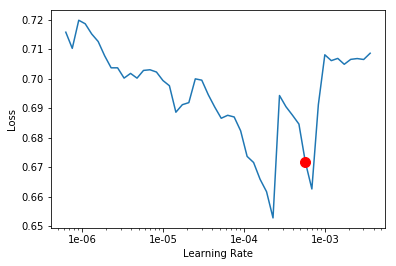

In [36]:
learner.recorder.plot(suggestion=True, skip_end=20)

In [37]:
#开始训练
learner.fit_one_cycle(config.epochs, slice(3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.286651,0.210489,0.908000,03:08
1,0.187557,0.171379,0.930000,03:09
2,0.127004,0.140221,0.950000,03:09
3,0.038747,0.172435,0.952000,03:09
4,0.008313,0.159150,0.959000,03:09


In [38]:
learner.save('htl_stage1')

In [39]:
learner.model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

In [40]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [128, 768]           16,226,304 True      
______________________________________________________________________
Embedding            [128, 768]           393,216    True      
______________________________________________________________________
Embedding            [128, 768]           1,536      True      
______________________________________________________________________
BertLayerNorm        [128, 768]           1,536      True      
______________________________________________________________________
Dropout              [128, 768]           0          False     
______________________________________________________________________
Linear               [128, 768]           590,592    True      
______________________________________________________________________
Linear               [128, 768]           590,592    True      
______________________________________________________________

In [41]:
learner.unfreeze()

In [42]:
learner.fit_one_cycle(3, slice(3e-5/2.6))

epoch,train_loss,valid_loss,accuracy,time
0,0.034001,0.352218,0.929000,03:09
1,0.014278,0.243409,0.950000,03:09
2,0.001612,0.281989,0.947000,03:09


In [43]:
learner.save('htl_stage2')

In [44]:
#用样例测试下
learner.predict("设施老化，紧靠马路噪音太大，晚上楼上卫生间的水流声和空调噪音非常大，无法入眠")

(Category 0, tensor(0), tensor([9.9972e-01, 2.8313e-04]))

In [45]:
learner.predict("位置真是好的没话讲，距解放碑步行只要两分钟不到，周边吃的、买的、看的都很多")

(Category 1, tensor(1), tensor([3.6966e-05, 9.9996e-01]))